In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import torch
import torchinfo
import torchtext
import torchtext.transforms as T
from torch.utils.data import DataLoader
from torchlake.common.controller.evaluator import ClassificationEvaluator
from torchlake.common.controller.trainer import ClassificationTrainer
from torchlake.common.schemas import NlpContext
from torchlake.common.utils.platform import get_file_size
from torchlake.common.utils.text import build_vocab, is_longer_text
from torchlake.sequence_data.models import GruClassifier
from torchlake.text_classification.datasets.ag_news.constants import \
    CLASS_NAMES
from torchtext.data.utils import get_tokenizer
from tqdm import tqdm

In [2]:
torch.__version__

'2.1.0+cu118'

In [3]:
torchtext.__version__

'0.16.0+cpu'

# setting


In [4]:
batch_size = 512
context = NlpContext()

In [5]:
tokenizer = get_tokenizer("basic_english")

In [6]:
artifact_path = Path("../../artifacts/gru")
dataset_path = Path("../../data/AGNews")

# dataset


In [7]:
def datapipe_factory(datapipe, transform=None):
    datapipe = (
        datapipe
            # (label, text) -> (text, label) 
            # label encode from 1-K to 0 - K-1 
            .map(lambda item: (item[1], item[0] - 1))
            .map(lambda item: (item[0].strip(), item[1]))
            .map(lambda item: (item[0].lower(), item[1]))
            .filter(lambda item: is_longer_text(item[0], context.min_seq_len))
            .map(lambda item: (tokenizer(item[0]), item[1]))
    )

    if transform:
        datapipe = datapipe.map(lambda item: (transform(item[0]), item[1]))

    return datapipe

In [8]:
train_datapipe, test_datapipe = torchtext.datasets.AG_NEWS(dataset_path.as_posix())

In [9]:
vocab = build_vocab(map(lambda x: x[0], datapipe_factory(train_datapipe)))

d:\research\pytorch-implementations\.venv\Lib\site-packages\torch\utils\data\datapipes\utils\common.py:141: UserWarning: Local function is not supported by pickle, please use regular python function or functools.partial instead.
  warnings.warn(


In [10]:
VOCAB_SIZE = len(vocab)
VOCAB_SIZE

30335

In [11]:
text_transform = T.Sequential(
    T.VocabTransform(vocab),
    T.Truncate(context.max_seq_len - 2),
    T.AddToken(token=context.bos_idx, begin=True),
    T.AddToken(token=context.eos_idx, begin=False),
    T.ToTensor(),
    T.PadTransform(context.max_seq_len, context.padding_idx),
)

In [12]:
train_datapipe = datapipe_factory(
    train_datapipe,
    text_transform,
)

test_datapipe = datapipe_factory(
    test_datapipe,
    text_transform,
)

d:\research\pytorch-implementations\.venv\Lib\site-packages\torch\utils\data\datapipes\utils\common.py:141: UserWarning: Local function is not supported by pickle, please use regular python function or functools.partial instead.
  warnings.warn(


In [13]:
train_dataloader = DataLoader(
    train_datapipe,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
)

test_dataloader = DataLoader(
    test_datapipe,
    batch_size=batch_size,
)

In [14]:
for text, label in train_dataloader:
    print(text.shape, label.shape)
    break

torch.Size([512, 256]) torch.Size([512])


# model


In [15]:
NUM_CLASS = len(CLASS_NAMES)

In [16]:
DEVICE = torch.device(context.device)

In [17]:
EMBED_DIM = 256
HIDDEN_DIM = 256
model = GruClassifier(
    VOCAB_SIZE,
    EMBED_DIM,
    HIDDEN_DIM,
    NUM_CLASS,
    num_layers=1,
    context=context,
).to(DEVICE)

In [18]:
torchinfo.summary(model)

Layer (type:depth-idx)                   Param #
GruClassifier                            --
├─Embedding: 1-1                         7,765,760
├─GRU: 1-2                               394,752
├─LayerNorm: 1-3                         512
├─Linear: 1-4                            1,028
Total params: 8,162,052
Trainable params: 8,162,052
Non-trainable params: 0

In [19]:
EPOCHES = 10

In [20]:
trainer = ClassificationTrainer(EPOCHES, DEVICE, feature_last=True)

In [21]:
criterion = trainer.get_criterion(NUM_CLASS, ignore_index=context.padding_idx)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [22]:
training_loss = trainer.run(train_dataloader, model, optimizer, criterion)

d:\research\pytorch-implementations\.venv\Lib\site-packages\torch\utils\data\datapipes\iter\combining.py:333: UserWarning: Some child DataPipes are not exhausted when __iter__ is called. We are resetting the buffer and each child DataPipe will read from the start again.
  warnings.warn("Some child DataPipes are not exhausted when __iter__ is called. We are resetting "
234it [00:31,  7.38it/s]


epoch 1 : 0.0007938271466519238


234it [00:32,  7.26it/s]


epoch 2 : 0.00029275109894418466


234it [00:34,  6.85it/s]


epoch 3 : 0.0002023768030419452


234it [00:33,  7.03it/s]


epoch 4 : 0.0001434238338877813


234it [00:31,  7.52it/s]


epoch 5 : 9.775499355370819e-05


234it [00:31,  7.46it/s]


epoch 6 : 7.33821744673065e-05


234it [00:31,  7.32it/s]


epoch 7 : 4.969056077150013e-05


234it [00:33,  7.05it/s]


epoch 8 : 3.448934206676507e-05


234it [00:33,  7.02it/s]


epoch 9 : 2.956930562119781e-05


234it [00:32,  7.26it/s]

epoch 10 : 2.4035610267751937e-05


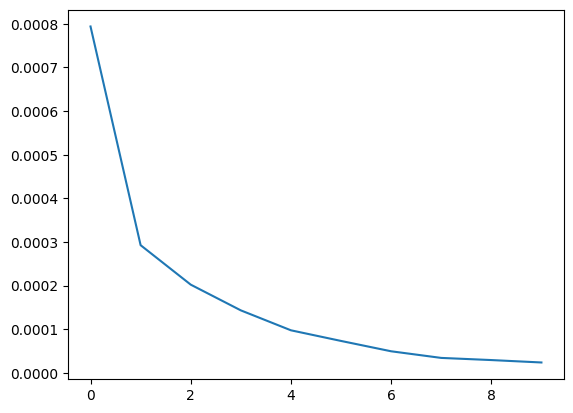

In [23]:
plt.plot(training_loss)

# inference


In [24]:
evaluator = ClassificationEvaluator(NUM_CLASS, DEVICE)

In [25]:
confusion_matrix = evaluator.run(test_dataloader, model)

15it [00:01,  9.12it/s]

[[1791   29   80    0]
 [  40 1827   33    0]
 [  78   13 1809    0]
 [ 477   72 1351    0]]


In [26]:
per_class_acc = evaluator.get_per_class_accuracy(confusion_matrix)
evaluator.show_per_class_accuracy(CLASS_NAMES , per_class_acc)

world     : 0.9426315789473684
sports    : 0.9615789473684211
business  : 0.9521052631578948
science   : 0.0


In [27]:
per_class_acc.mean()

0.714078947368421

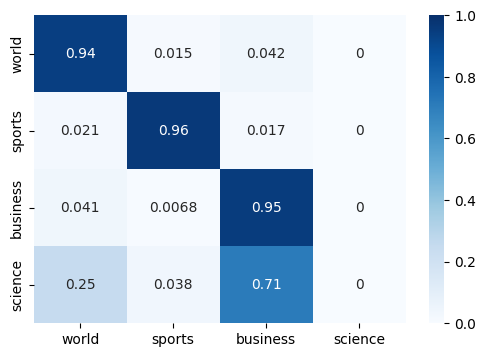

In [28]:
evaluator.plot_confusion_matrix(
    confusion_matrix,
    CLASS_NAMES,
    "Blues",
    annot=True,
    figsize=(6, 4),
)

In [29]:
model_path = artifact_path.joinpath("gru.pth")

In [30]:
torch.save(model.state_dict(), model_path)

In [31]:
get_file_size(model_path)

'31.14MB'

In [32]:
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>